

In this Notebook, examples of code for generative models will be presented as part of the educational content. Following this, you will have a task focused on fine-tuning pre-trained diffusion models on medical images and texts. In this project, we aim to cover various topics, including the concepts of generative models, fine-tuning using the LoRA model, and self-supervised learning.

## Stable Diffusion

Stable Diffusion is a technique used for generating high-quality images from text descriptions. It works by gradually adding noise to an image and then reversing the process to refine the image, guided by the text prompt. The model starts with random noise and iteratively denoises it, aligning the output with the input text. This approach allows for creating detailed and coherent images, making it popular for various creative applications.

You can read more about diffusion models <a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb">here</a>


### Setup & Imports

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 14 11:41:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              27W /  70W |    347MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --upgrade transformers==4.40.0 diffusers==0.27.2 ftfy==6.2.0 accelerate datasets bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: transformers
    Fou

In [ ]:
from argparse import Namespace
import math
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler, DDPMScheduler
from accelerate import Accelerator
from accelerate.utils import set_seed
import bitsandbytes as bnb

In [ ]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(64)   # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch_device

### Importing Models

Stable Diffusion utilizes multiple models to operate. As it is demonstrated in the image below the process consists of multiple steps:
- The process starts with a tensor of random numbers, chosen as the initial embedding of the image.
- Simultaneously, a text prompt provided by the user is tokenized and converted into an embedding.
- Both embeddings are combined and fed into a U-Net model.
- The U-Net model goes through multiple iterations, gradually reducing the noise in the image.
- The scheduler defines the algorithm for noise reduction.
- Finally, the refined embedding is passed through the decoder of a VAE (Variational Autoencoder) to produce the output image.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>


To start, first we have to import all the required models.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# The UNet model for generating the latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

We will define a function to convert the latent outputs to images.

In [ ]:
def latents_to_pil(latents):

    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

### Prompt to Embedding


To provide the U-net model with text guidance, we need to convert text inputs to embeddings.

It's important to note that the U-net model requires a positive embedding and also a negative embedding. The code for positive embedding is provided to you. As part of the homework try writing the code for getting the negative embedding. Since we are not going to provide any negative prompt, You can use empty strings.

In [ ]:
def prompt_to_emb(prompt):
    batch_size = len(prompt)
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    prompt_embeds = text_encoder(text_input_ids.to(device))
    prompt_embeds = prompt_embeds[0]
    prompt_embeds_dtype = text_encoder.dtype
    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)
    _, seq_len, _ = prompt_embeds.shape
    prompt_embeds = prompt_embeds.repeat(1, 1, 1)
    prompt_embeds = prompt_embeds.view(batch_size * 1, seq_len, -1)
    max_length = prompt_embeds.shape[1]

    negative_text_inputs = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
    )
    negative_text_input_ids = negative_text_inputs.input_ids
    negative_prompt_embeds = text_encoder(negative_text_input_ids.to(device))
    negative_prompt_embeds = negative_prompt_embeds[0]
    negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)
    negative_prompt_embeds = negative_prompt_embeds.repeat(1, 1, 1)
    negative_prompt_embeds = negative_prompt_embeds.view(batch_size * 1, seq_len, -1)
    concatenated_embeddings = torch.cat([negative_prompt_embeds, prompt_embeds])

    return concatenated_embeddings
prompt_embeddings = prompt_to_emb(["A photo of a cat"])
print(prompt_embeddings.shape)

torch.Size([2, 77, 768])


### Embeding to Latents

This is the part where the input Embeddings go through multiple iterations to produce the image embedding.

In [ ]:
def emb_to_latents(text_embeddings):

    scheduler.set_timesteps(num_inference_steps)

    # Generate random latent noise for the input to the model
    latents = torch.randn((1, 4, 64, 64),dtype=torch.float32).to(torch_device)

    for t in tqdm(scheduler.timesteps):
        # Duplicate the random latent noise
        latent_model_input = torch.cat([latents] * 2)

        # Scale the model input
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings,return_dict=False,added_cond_kwargs={'text_embeds':text_embeddings})[0]

        # Apply classifier-free guidance scale
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents,return_dict=False)[0]

    return latents

### Evaluate

Let's try the pipeline with a few examples.

  0%|          | 0/51 [00:00<?, ?it/s]

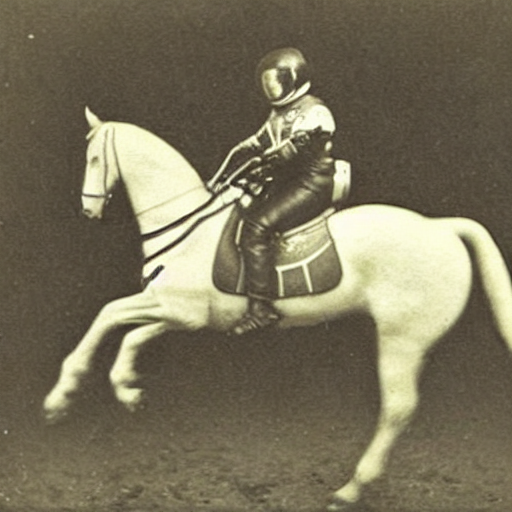

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

  0%|          | 0/51 [00:00<?, ?it/s]

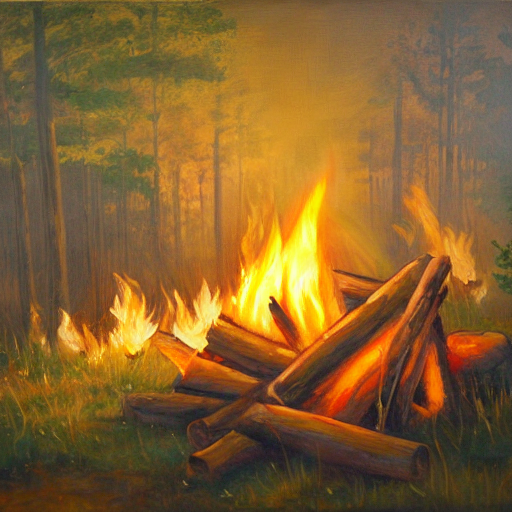

In [ ]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

# Task



In this task, we aim to fine-tune the Stable Diffusion model for generating medical images using input text. The model ID is provided in the code for your convenience. You need to download the medical images and texts from the link below and convert the texts inside the `.txt` files into the following format:

```
Age: age_number, Gender: gender_type, findings: findings#1. findings#2. ..
```

The `.txt` files contain information in the format:

```
gender_type age_numberyrs
findings#1
findings#2
...
```

Note that there may or may not be certain symbols between `gender_type` and `age_number`. You must handle all scenarios appropriately. Additionally, in the part referring to `age_number`, the three letters `yrs` are included but should not be incorporated into your prompt.

After constructing the prompts, create a CSV file with the following headers:

```
filename, findings
```

In the `filename` column, include the name of each image, and in the `findings` column, add the constructed prompt. For example:

```
filename, findings
example.png, "Age: 24, Gender: Male, findings: normal"
```

Now your dataset is ready.

You will train the model on this dataset. The training process will follow the standard approach for training diffusion models conditioned on input text. That is, an input image is fed into the model, noise is added, the input prompt is encoded and fused with the image encoding, and during the denoising process, the model attempts to learn the noise for the image.

This type of training is self-supervised, as there are no actual labels in this problem, and during training, we generate labels for the inputs.

For fine-tuning, we will use the **LoRA (Low-Rank Adaptation)** method.

In this method, only the `Linear` layers within the **UNet** and **text encoder** components will be called and replaced with LoRA-specific layers, while the rest of the model remains frozen. You must implement this method from scratch.

Here is the process:
1. Define your custom `LoRALinear` layer.
2. Replace the existing `Linear` layers in the **UNet** and **text encoder** components with your `LoRALinear` layer.
3. Freeze the rest of the model and train only these LoRA layers.


Download the dataset from the following link **CXR_png** and **ClinicalReadings** dir

[link](https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/index.html)

In [1]:
import os, gc, sys, time, random, math
import torch
import torch.nn as nn
import torch.nn.functional as F


from typing import Optional, List

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

try:
    from diffusers import StableDiffusionPipeline
except:
    !pip install diffusers -q
    from diffusers import StableDiffusionPipeline

from tqdm import tqdm

from PIL import Image

import numpy as np
import pandas as pd

DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seedBasic(); seedTorch();

def clear_cache():
    torch.cuda.empty_cache(); gc.collect(); time.sleep(1); torch.cuda.empty_cache(); gc.collect();


def check_and_make_folder(path):
    if not os.path.exists(path):
        os.system(f'mkdir -p {path}')


In [2]:
def print_trainable_parameters(model):
    total_parameter_count = sum([np.prod(p.size()) for p in model.parameters()])

    trainable_parameter = filter(lambda p: p.requires_grad, model.parameters())
    trainable_parameter_count = sum([np.prod(p.size()) for p in trainable_parameter])

    trainable_percentage = (trainable_parameter_count / total_parameter_count)  * 100

    formatted_output = (
        f"trainable params: {trainable_parameter_count:,} || "
        f"all params: {total_parameter_count:,} || "
        f"trainable%: {trainable_percentage:.16f}"
    )

    print(formatted_output)


def remove_param_from_optimizer(optim, param):
    for j in range(len(optim.param_groups)):
        optim_param_group_list = optim.param_groups[j]["params"]
        for i, optim_param in enumerate(optim_param_group_list):
            if param.shape == optim_param.shape and (param==optim_param).all():
                del optim.param_groups[j]["params"][i]

clear_cache()

In [3]:
WEIGHT_DTYPE = torch.float32
BATCH_SIZE = 1
LR = 1e-4
# The main path
Main_Path = '/content'
# The datasets path under the main path
Data_storage = Main_Path + '/dataset'
save_result_path = Main_Path + '/Result'

### folder to save the result.
folder_name = 'LoRA'

check_and_make_folder(f'{save_result_path}/{folder_name}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_id = "runwayml/stable-diffusion-v1-5"

UNET_TARGET_MODULES = [
    "to_q", "to_k", "to_v",
    "proj", "proj_in", "proj_out",
    "conv", "conv1", "conv2",
    "conv_shortcut", "to_out.0", "time_emb_proj", "ff.net.2",
]


TEXT_ENCODER_TARGET_MODULES = ["fc1", "fc2", "q_proj", "k_proj", "v_proj", "out_proj"]

In [4]:
"""
Prepare a Stable Diffusion model for fine-tuning or targeted use by loading its components,
extracting key modules, and freezing certain parts to preserve their pretrained functionality.
"""

pipe = ...

tokenizer = ...
noise_scheduler = ...
text_encoder = ...
vae = ...
unet =...

# Freeze the Bulk part of the model
text_encoder...
vae...
unet...

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
def remove_param_from_optimizer(optim, param):
    for j in range(len(optim.param_groups)):
        optim_param_group_list = optim.param_groups[j]["params"]
        for i, optim_param in enumerate(optim_param_group_list):
            if param.shape == optim_param.shape and (param==optim_param).all():
                del optim.param_groups[j]["params"][i]

clear_cache()

In [6]:
class LoRALayer():
    def __init__(
        self,
        r: int,
        lora_alpha: int,
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights

### This is the LoRA replacement of nn.Linear layer
class Linear(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_features: int,
        out_features: int,
        name = '',
        r: int = 0,
        lora_alpha: int = 8,
        lora_dropout: float = 0.,
        EMA_factor: float = 0.6,
        # warmup_step_per_expand:int = 10,
        fan_in_fan_out: bool = False, # Set this to True if the layer to replace stores weight like (fan_in, fan_out)
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)
        self.name = name
        self.in_features = in_features
        self.out_features = out_features
        self.r = r
        self.fan_in_fan_out = fan_in_fan_out
        # Actual trainable parameters
        if r > 0:
            # Define A and B matrices with proper shape
            self.lora_A ...
            self.lora_B ...
            # define scaling variable
            self.scaling ...
            # Freezing the pre-trained weight matrix
            self.weight....

            self.recorded_grad = 1

        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.T

    def get_active_rank(self):
        assert self.lora_A.shape[0] == self.lora_B.shape[1]
        return self.lora_A.shape[0]

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            nn.init.kaiming_uniform_(self.lora_A)
            nn.init.kaiming_uniform_(self.lora_B)


    def train(self, mode: bool = True):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if self.merge_weights and self.merged:
            # Make sure that the weights are not merged
            if self.r > 0:
                # training of LoRA layer used in backward
                self.weight.data ...
            self.merged = False

    def eval(self):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.eval(self)
        if self.merge_weights and not self.merged:
            # Merge the weights and mark it
            if self.r > 0:
                # validating of LoRA layer (merging weights phase)
                self.weight.data ...

            self.merged = True

    def forward(self, x: torch.Tensor, *args, **kwargs):
        def T(w):
            return w.T if self.fan_in_fan_out else w

        if self.r > 0 and not self.merged:
            # LoRA forwarding: res = orig_w * x + alpha * delta_w * drop_out(x)
            result ...

            if self.r > 0:
                result += ...
            return result
        else:
            return F.linear(x, T(self.weight), bias=self.bias)

In [7]:
text_encoder = pipe.text_encoder
text_encoder = text_encoder.requires_grad_(False)
unet = pipe.unet
unet = unet.requires_grad_(False)

def set_Linear_SeLoRA(model):
    # Replace all linear layers with LoRA layers
    # Set LoRA weight and bias from original layer
    # freeze pretrained weights and bias
    # pay attention to the shapes transfer
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            LoRA_layer = ...

            # Navigate through the model hierarchy to replace the layer
            parent_module = model
            sub_layers = name.split('.')
            for layer_name in sub_layers[:-1]:
                parent_module = getattr(parent_module, layer_name)

            setattr(parent_module, sub_layers[-1], LoRA_layer)
    return model


# unet_lora = unet
unet_lora = set_Linear_SeLoRA(unet)
text_encoder_lora = set_Linear_SeLoRA(text_encoder)

print_trainable_parameters(text_encoder_lora)
print_trainable_parameters(unet_lora)

trainable params: 663,552 || all params: 123,724,032 || trainable%: 0.5363161782506409
trainable params: 1,705,984 || all params: 861,226,948 || trainable%: 0.1980876241694193


In [8]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, df, tokenizer, size = 224, center_crop = True):
        self.root_dir = root_dir
        self.files = df['filename'].tolist()
        self.findings = df['findings'].tolist()
        self.tokenizer = tokenizer
        self.image_transforms = transforms.Compose(
            [
                ... # Do resize and use bilinear interpolation
                ... # Do centercrop or randomcrop as needed
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        example = {}
        instance_image = Image.open(
            os.path.join(self.root_dir, self.files[idx])
        ).convert("RGB")

        # apply image transformations on instance image
        example["instance_images"] = ...
        '''
        tokenize a specific text instance (self.findings[idx]) using a tokenizer and
        prepare it as a padded and truncated sequence of token IDs in PyTorch tensor format.
        '''
        example["instance_prompt_ids"] = ...

        return example


In [9]:
from sklearn.model_selection import train_test_split

reports = pd.read_csv('/content/image_findings.csv')
reports = reports[['filename', 'findings']]

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(reports, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.2, random_state=42)

# ImageDataset initialization
train_ds = ImageDataset(
    ...,
)

valid_ds = ImageDataset(
    ...,
)

test_ds = ImageDataset(
    ...,
)

num_workers = os.cpu_count()

# DataLoader initialization
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=..., num_workers = num_workers)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=..., num_workers = num_workers)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=..., num_workers = num_workers)


In [10]:
# optimize proper parameters
optimizer = torch.optim.Adam(..., lr=LR)

In [11]:
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display
import copy


class Trainer:
    def __init__(self, vae, unet, text_encoder, noise_scheduler, optimizer, train_dl, test_dl, total_epoch, WEIGHT_DTYPE, threshould = 2, per_iter_valid = 60, log_period = 20):
        self.vae = vae.to(device, dtype=WEIGHT_DTYPE)
        self.unet = unet.to(device, dtype=WEIGHT_DTYPE)
        self.text_encoder = text_encoder.to(device, dtype=WEIGHT_DTYPE)
        self.noise_scheduler = noise_scheduler
        self.optimizer = optimizer
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.WEIGHT_DTYPE = WEIGHT_DTYPE
        self.total_epoch = total_epoch
        self.threshould = threshould
        self.per_iter_valid = per_iter_valid
        self.total_step = 0
        self.result_df = pd.DataFrame(columns=['epoch', 'steps', 'Train Loss', 'Valid Loss'])
        self._display_id = None
        self.log_period = log_period

        self.best_text_encoder = None
        self.best_unet = None

        self.display_line = ''

        print(f'total steps: {len(train_dl) * total_epoch}')

    def valid(self):
        self.unet.eval()
        self.text_encoder.eval()
        self.vae.eval()

        valid_pbar = tqdm(self.test_dl, desc = 'validating', leave = False)

        valid_loss, number_of_instance = [], 0

        for step, batch in enumerate(valid_pbar):
            # define batch, transfer to device, convert to weight's dtype, squeeze if needed.
            pixel_values = ...
            pormpt_idxs  = ...

            # Convert input images (pixel values) to latent representations in the latent space using the VAE encoder
            latents = ...
            # Scale the latent representations by the scaling factor from the VAE configuration
            latents = ...

            # Generate random noise of the same shape as the latents to simulate the diffusion process
            noise = ...
            bsz = latents.shape[0]
            # Sample random timesteps for each image, uniformly drawn from the range of timesteps in the noise scheduler
            timesteps = ...
            timesteps = ... #convert to long

            # Add noise to the latents at the selected timesteps according to the noise magnitude (forward diffusion process)
            noisy_latents = ...


            # Encode the text prompts into hidden states using the text encoder, which provides conditioning information
            encoder_hidden_states = ...
            # Predict the noise residual using the UNet model, conditioned on the noisy latents, timesteps, and text embeddings
            model_pred = ...
            # Define the target for the loss function
            target = ...
            # Calculate the loss between the predicted noise (model output) and the actual noise
            # This measures how well the model predicts the noise for the reverse diffusion process
            loss = ...

            valid_loss.append(loss.item() * len(batch))
            number_of_instance += len(batch)
            clear_cache()
            torch.cuda.empty_cache()


        ########################################################################
        ## add log and save model here TODO
        ########################################################################

        self.unet.train()
        self.vae.train()
        self.text_encoder.train()

        torch.cuda.empty_cache()

        return sum(valid_loss) / number_of_instance

    def train(self):

        self._display_id = display(self.result_df, display_id=True)
        self.rank_display_id = display('', display_id=True)

        self.vae.train()
        self.unet.train()
        self.text_encoder.train()


        recorded_loss = []

        for epoch in range(self.total_epoch):

            pbar = tqdm(self.train_dl)
            for step, batch in enumerate(pbar):

                pixel_values = batch["instance_images"].to(device, dtype=self.WEIGHT_DTYPE)
                pormpt_idxs  = batch["instance_prompt_ids"].to(device).squeeze(1)

                # Convert input images (pixel values) to latent representations in the latent space using the VAE encoder
                latents = ...
                # Scale the latent representations by the scaling factor from the VAE configuration
                latents = ...

                # Generate random noise of the same shape as the latents to simulate the diffusion process
                noise = ...
                bsz = latents.shape[0]
                # Sample random timesteps for each image, uniformly drawn from the range of timesteps in the noise scheduler
                timesteps = ...
                timesteps = ... #convert to long

                # Add noise to the latents at the selected timesteps according to the noise magnitude (forward diffusion process)
                noisy_latents = ...


                # Encode the text prompts into hidden states using the text encoder, which provides conditioning information
                encoder_hidden_states = ...
                # Predict the noise residual using the UNet model, conditioned on the noisy latents, timesteps, and text embeddings
                model_pred = ...
                # Define the target for the loss function
                target = ...
                # Calculate the loss between the predicted noise (model output) and the actual noise
                # This measures how well the model predicts the noise for the reverse diffusion process
                loss = ...

                self.optimizer.zero_grad()

                loss.backward()

                recorded_loss.append(loss.item())

                pbar.set_description(f"[Loss: {recorded_loss[-1]:.3f}/{np.mean(recorded_loss):.3f}]")

                self.optimizer.step()

                self.total_step += 1

                clear_cache()


                if self.total_step % self.per_iter_valid == 0:

                    valid_rmse = self.valid()

                    if valid_rmse <= min([x for x in trainer.result_df['Valid Loss'] if x != ' --- '] + [1.0]):

                        self.best_text_encoder = copy.deepcopy(self.text_encoder).cpu()
                        self.best_unet = copy.deepcopy(self.unet).cpu()

                        check_and_make_folder(f'{save_result_path}/{folder_name}/trained_model')
                        check_and_make_folder(f'{save_result_path}/{folder_name}/trained_model/final_Unet')
                        check_and_make_folder(f'{save_result_path}/{folder_name}/trained_model/final_Text')

                        self.unet.save_pretrained(f'{save_result_path}/{folder_name}/trained_model/final_Unet')
                        self.text_encoder.save_pretrained(f'{save_result_path}/{folder_name}/trained_model/final_Text')


                    self.result_df.loc[len(self.result_df)] = [epoch, self.total_step, np.round(np.mean(recorded_loss), 4), np.round(valid_rmse, 4)]


                    self._display_id.update(self.result_df)

                    recorded_loss = []

                if self.total_step % self.log_period == 0:

                    self.result_df.loc[len(self.result_df)] = [epoch, self.total_step, np.round(np.mean(recorded_loss), 4), ' --- ']

                    self._display_id.update(self.result_df)

                    self.result_df.to_csv(f'{save_result_path}/{folder_name}/results.csv')


trainer = Trainer(
    vae = vae,
    unet = unet_lora,
    text_encoder = text_encoder_lora,
    noise_scheduler = noise_scheduler,
    optimizer = optimizer,
    train_dl = train_loader,
    test_dl = valid_loader,
    total_epoch = 10,
    WEIGHT_DTYPE = WEIGHT_DTYPE,
    threshould = 1.3,
    per_iter_valid = len(train_loader),
    log_period = 40,
)


trainer.train()


total steps: 5290


epoch  steps  Train Loss Valid Loss
0     0.0   40.0      0.8671       --- 
1     0.0   80.0      0.8361       --- 
2     0.0  120.0      0.8195       --- 
3     0.0  160.0      0.7954       --- 
4     0.0  200.0      0.7699       --- 
5     0.0  240.0      0.7369       --- 
6     0.0  280.0      0.7098       --- 
7     0.0  320.0      0.6719       --- 
8     0.0  360.0      0.6436       --- 
9     0.0  400.0      0.6167       --- 
10    0.0  440.0      0.5924       --- 
11    0.0  480.0      0.5672       --- 
12    0.0  520.0      0.5494       --- 
13    0.0  529.0      0.5420     0.2742
14    1.0  560.0      0.2318       --- 
15    1.0  600.0      0.2613       --- 
16    1.0  640.0      0.2911       ---

''

  0%|          | 0/529 [00:00<?, ?it/s]

validating:   0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
trainer.result_df.to_csv(f'{save_result_path}/{folder_name}/results.csv')

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

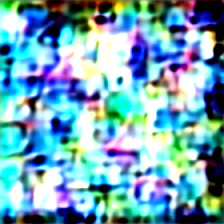

  0%|          | 0/50 [00:00<?, ?it/s]

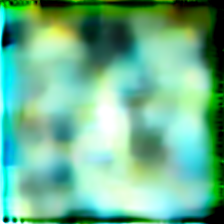

  0%|          | 0/50 [00:00<?, ?it/s]

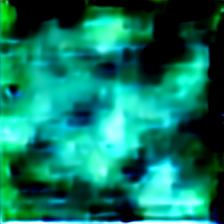

  0%|          | 0/50 [00:00<?, ?it/s]

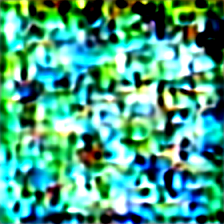

  0%|          | 0/50 [00:00<?, ?it/s]

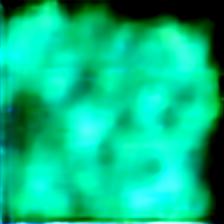

  0%|          | 0/50 [00:00<?, ?it/s]

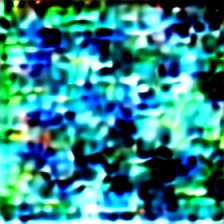

  0%|          | 0/50 [00:00<?, ?it/s]

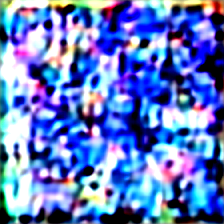

  0%|          | 0/50 [00:00<?, ?it/s]

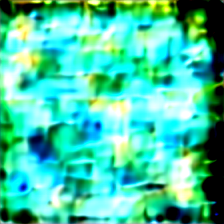

  0%|          | 0/50 [00:00<?, ?it/s]

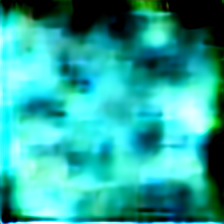

  0%|          | 0/50 [00:00<?, ?it/s]

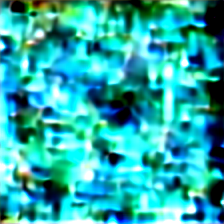

  0%|          | 0/50 [00:00<?, ?it/s]

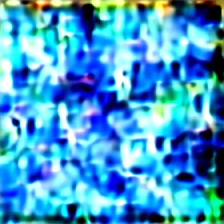

  0%|          | 0/50 [00:00<?, ?it/s]

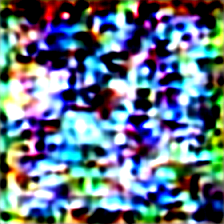

  0%|          | 0/50 [00:00<?, ?it/s]

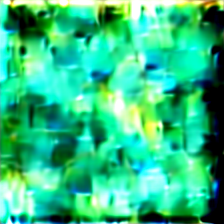

  0%|          | 0/50 [00:00<?, ?it/s]

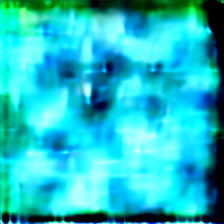

  0%|          | 0/50 [00:00<?, ?it/s]

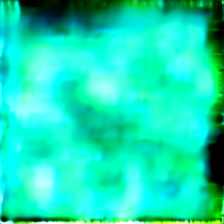

  0%|          | 0/50 [00:00<?, ?it/s]

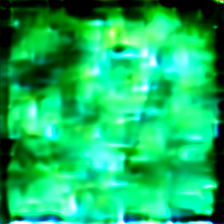

  0%|          | 0/50 [00:00<?, ?it/s]

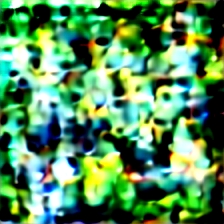

  0%|          | 0/50 [00:00<?, ?it/s]

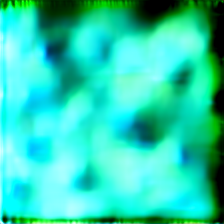

  0%|          | 0/50 [00:00<?, ?it/s]

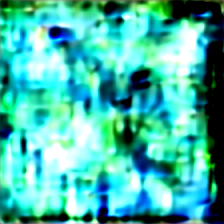

  0%|          | 0/50 [00:00<?, ?it/s]

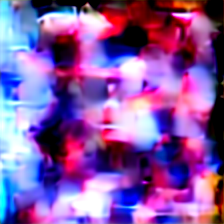

  0%|          | 0/50 [00:00<?, ?it/s]

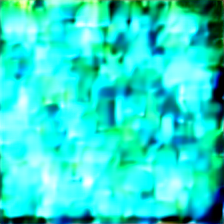

  0%|          | 0/50 [00:00<?, ?it/s]

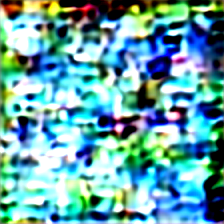

  0%|          | 0/50 [00:00<?, ?it/s]

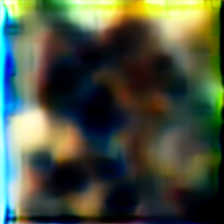

  0%|          | 0/50 [00:00<?, ?it/s]

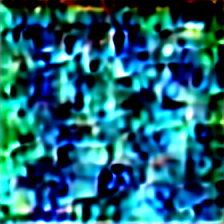

  0%|          | 0/50 [00:00<?, ?it/s]

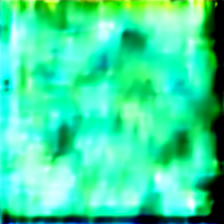

  0%|          | 0/50 [00:00<?, ?it/s]

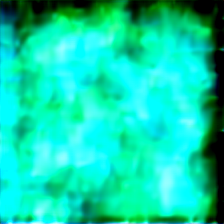

  0%|          | 0/50 [00:00<?, ?it/s]

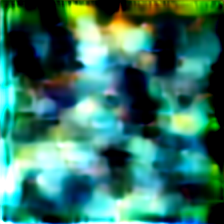

In [13]:
unet_lora.eval()
text_encoder_lora.eval()
clear_cache()

"""
assembles a customized Stable Diffusion pipeline for image generation
using the fine-tuned components (best_text_encoder, best_unet, etc.)
beside old components (vae, noise scheduler, tokenizer, etc.)
"""
new_pipe = ...

new_pipe.to(device)

check_and_make_folder(f'{save_result_path}/{folder_name}')
check_and_make_folder(f'{save_result_path}/{folder_name}/test_images')

for place in range(len(test_df)):
    temp_prompts = test_df.findings.iloc[place]

    # generate new 224*224 image from input prompt
    temp = ...

    temp.save(f'{save_result_path}/{folder_name}/test_images/{place}.png')

    display(temp)